In [716]:
import matplotlib.pyplot as plt
import importlib
import bitmap_editor
importlib.reload(bitmap_editor)
import numpy as np

height = 20
width = 20
bitmap_matrix = np.zeros(shape=(height,width))
bitmapEditor = bitmap_editor.BitmapEditor(bitmap_matrix)

Canvas(height=200, width=200)

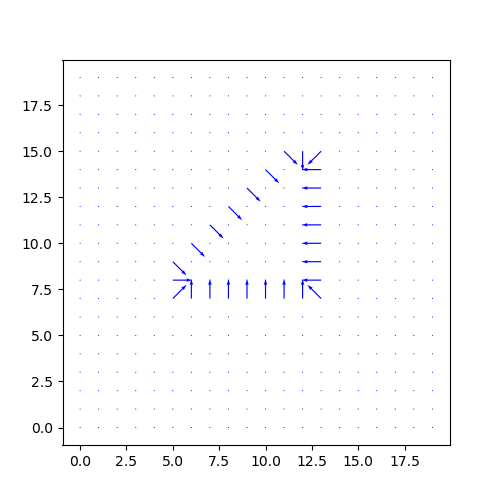

In [719]:
import navier_stokes
importlib.reload(navier_stokes)

grid = np.flip(np.copy(bitmap_matrix), 0)

######### Actual simulation code

cells = navier_stokes.cells(grid)
A, b = navier_stokes.projection_A(cells)

################
X, Y = np.meshgrid(np.arange(width), np.arange(height))
NormalsU = np.zeros(shape=(height, width))
NormalsV = np.zeros(shape=(height, width))

for cell in cells.flat:
    normal = np.array([0, 0])
    if isinstance(cell, navier_stokes.BoundaryCell):
        normal = cell.normal
    NormalsU[cell.index] = normal[0]
    NormalsV[cell.index] = normal[1]


%matplotlib widget
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, NormalsU, NormalsV, color="b", scale=20)
plt.show()

In [597]:

with np.printoptions(threshold=np.inf):
    print(A)

print(b)
print(len(b))
print(A.shape)

[[-4.   1.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0. ]
 [ 0.   0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.   1.  -4.   1.   0.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   

8
5.576538605997315e-08
0.006653955954488702


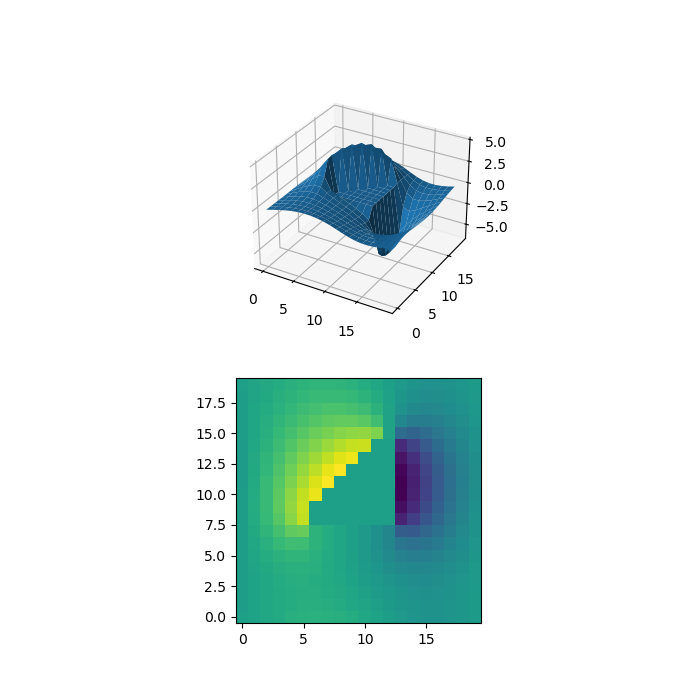

In [723]:
%matplotlib widget
import pyamg

ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
residuals = []
x = ml.solve(b, tol=1e-8, maxiter=100, residuals=residuals)
print(len(residuals))
print(residuals[-1])
# x = np.linalg.solve(A,b)

# print(x)

mesh = np.zeros(shape=(height,width))

avg = np.average(x)
# print(avg)

for cell in cells.flat:
    if isinstance(cell, navier_stokes.ObstacleInteriorCell):
        mesh[cell.index] = avg
        continue
    if isinstance(cell, navier_stokes.FluidCell):
        mesh[cell.index] = x[cell.num]

for cell in cells.flat:
    if isinstance(cell, navier_stokes.BoundaryCell):
        w = np.array([1, 0])
        # g = (other_x*abs(nx) + other_y*abs(ny) + b)/(np.abs(nx + ny))
        an_x = np.abs(cell.normal[0])
        an_y = np.abs(cell.normal[1])
        mesh[cell.index] = np.dot(w, cell.normal)/(an_x + an_y)
        if cell.x_diff:
            mesh[cell.index] += mesh[cell.x_diff.fluid_cell.index]*an_x/(an_x + an_y)
        if cell.y_diff:
            mesh[cell.index] += mesh[cell.y_diff.fluid_cell.index]*an_y/(an_x + an_y)


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)
ax2.imshow(mesh, interpolation='none', origin='lower')

# plt.imshow(mesh, interpolation='none', origin='lower')
ax.plot_surface(X,Y,mesh) 
plt.show()

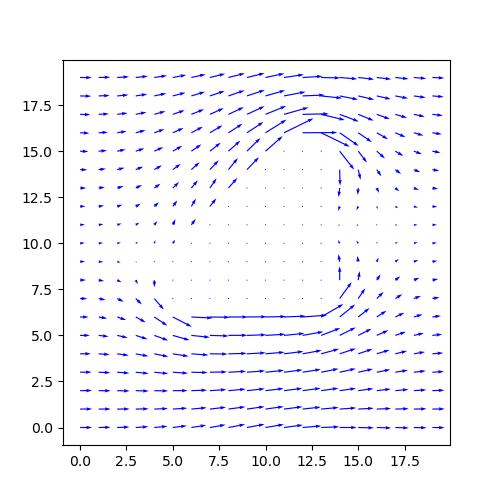

In [721]:
U = np.zeros(shape=mesh.shape)
V = np.zeros(shape=mesh.shape)

for cell in [c for c in cells.flat if isinstance(c, navier_stokes.FluidCell)]:
    j,i = cell.j, cell.i
    U[j][i] = (mesh[j][(i+1)%width] - mesh[j][(i-1)%width])/2
    V[j][i] = (mesh[(j+1)%height][i] - mesh[(j-1)%height][i])/2

newU = 1-U

for j,i in np.ndindex(mesh.shape):
    if grid[j][i]:
        newU[j][i]=0

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, newU, -V, color="b")
# ax.quiver(X, Y, U,V, color="r")
plt.show()